<a href="https://colab.research.google.com/github/anu-007/make_more_hashtags/blob/main/mlp/make_more_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import json
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [5]:
tags = []
with open('./tags.json', 'r') as file:
    data = json.load(file)
    for d in data:
      tags.append(d[0])
len(tags)

681

In [7]:
vocab = sorted(list(set(''.join(tags))))
stoi = {s:i+1 for i, s in enumerate(vocab)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [36]:
import random

# test, train, dev split for dataset
block_size = 3
def build_dataset(tags):
  X, Y = [], []
  for tag in tags:
    context = [0] * block_size
    for ch in tag + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(tags)
n1 = int(0.8*len(tags))
n2 = int(0.9*len(tags))

Xtr, Ytr = build_dataset(tags[:n1])
Xdev, Ydev = build_dataset(tags[n1:n2])
Xte, Yte = build_dataset(tags[n2:])

torch.Size([6591, 3]) torch.Size([6591])
torch.Size([808, 3]) torch.Size([808])
torch.Size([880, 3]) torch.Size([880])


In [136]:
vocab_len = max(stoi.values()) + 1
n_hidden = 100
n_embed = 2

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_len, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / ((n_embed * block_size)**0.5)
# B1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_len), generator=g) * 0.01
B2 = torch.randn(vocab_len, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, B1, W2, B2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

5953


In [123]:
(5/3) / ((n_embed * block_size)**0.5)

0.6804138174397718

In [137]:
max_step = 10000
batch_size = 32
lossi = []

for i in range(max_step):
  #minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb = Xtr[ix]
  Yb = Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+ B1
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


  h = torch.tanh(hpreact)
  logits = h @ W2 + B2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 7000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0:
    print(f'{i:7d}/{max_step:7d} : {loss.item():4f}')
  lossi.append(loss.log10().item())
  # break

      0/  10000 : 3.930095
   1000/  10000 : 2.832633
   2000/  10000 : 2.478164
   3000/  10000 : 2.228528
   4000/  10000 : 2.113358
   5000/  10000 : 2.297173
   6000/  10000 : 1.920719
   7000/  10000 : 1.834239
   8000/  10000 : 2.229421
   9000/  10000 : 2.345275


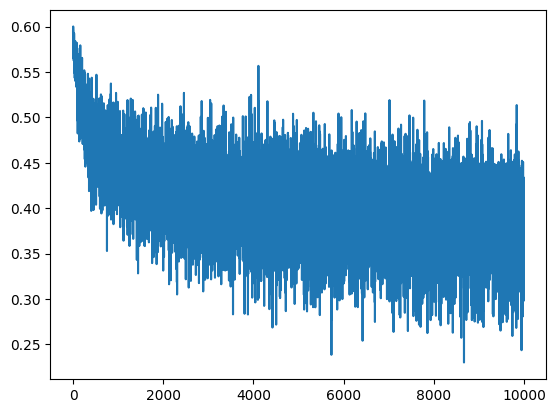

In [130]:
plt.plot(lossi)

In [144]:
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'dev': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + B1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + B2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.984360694885254
dev 3.078185796737671


In [132]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + B1)
    logits = h @ W2 + B2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

Bnting.
Plp.
fer.
Ieting.
udtoc.
wring.
e.
lLtirgutegtosmentelalbelkenutBwtacy.
hirg.
Vnty.
cumginesatcing.
Cetesrceetals.
b.
jetking.
Acs.
anc.
tegs.
dclocmenc.
Pnt.
acthcelkcerer.
